In [55]:
import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import math

%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device=",device)
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
import pdb

device= cuda


# VGGnet design 

In [56]:
class vggNet(torch.nn.Module):
    def __init__(self,in_channels=1,num_classes=10):
        self.in_channels = in_channels
        self.num_classes = num_classes
        
        super(vggNet,self).__init__()
        self.conv_layers = nn.Sequential(

            nn.Conv2d(self.in_channels,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
           
            
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512,out_features=4096),
            nn.ReLU(),
            nn.Dropout1d(0.5),
            nn.Linear(in_features=4096,out_features=4096),
            nn.ReLU(),
            nn.Dropout1d(0.5),
            nn.Linear(4096,self.num_classes)

            )
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer  = optim.SGD(self.parameters(),lr=0.001,momentum=0.9)
    def forward(self,x):
        x=self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    def do_train(self,train_data_loder,test_data_loder,num_epochs,batch_size,device):
        train_len = len(train_data_loder)*batch_size
        test_len = len(test_data_loder)*batch_size
        total_step = len(train_data_loder)*batch_size
        # Record loss
        train_loss = []
        test_loss =  []

        # Record accuracy
        train_accuracy  = []
        test_accuracy = []
        
        for epoch in range(num_epochs):
            # training the model 
            self.train()
            for i,(images,labels) in enumerate(train_data_loder):
                #move the input data to device
                images=images.to(device)
                labels=labels.to(device)
                #run the model on the input data
                outputs = model(images)
                # cal the loss
                loss = self.criterion(outputs,labels)
                # backprop
                self.optimizer.zero_grad()
                # do backprop
                loss.backward()
                # update the params
                self.optimizer.step() 
            #  evaluating the model to compute the training, testing  accuracy, and loss  at the current epoch
            self.eval()
            correct_predictions =0
            loss = 0
            with torch.no_grad():
                for data in train_data_loder:
                    #accuracy
                    images,true_labels = data
                    images,true_labels = images.to(device),true_labels.to(device)
                    nn_outputs=self(images).to(device)
                    _,predicted = torch.max(nn_outputs.data,1)
                    correct_predictions += (predicted == true_labels).sum().item()
                    #loss
                    loss += self.criterion(nn_outputs,true_labels).item()
            train_loss.append( loss / train_len )
            train_accuracy.append(correct_predictions / train_len )
            train_acc_i = correct_predictions / train_len 
            # For Test accuracy and test loss
            correct_predictions =0
            loss = 0
            with torch.no_grad():
                for data in test_data_loder:
                    #accuracy
                    images,true_labels = data
                    images,true_labels = images.to(device),true_labels.to(device)
                    nn_outputs=self(images).to(device)
                    _,predicted = torch.max(nn_outputs.data,1)
                    correct_predictions += (predicted == true_labels).sum().item()
                    #loss
                    loss += self.criterion(nn_outputs,true_labels).item()
            test_loss.append( loss / test_len )
            test_accuracy.append(correct_predictions / test_len )
            test_acc_i = correct_predictions / test_len 
            print(f'Epoch done [{epoch+1}], training-Acccuracy: {train_acc_i:.4f} , testing-accuracy:{test_acc_i }')
        print('Finished')
        return train_loss, train_accuracy, test_loss, test_accuracy
    def evaluate_(self,eval_datas,batch_size,device): 
        self.eval()
        correct_predictions =0
        loss = 0
        test_loss = []
        test_accuracy = []
        test_len = len(eval_datas)*batch_size
        with torch.no_grad():
            for data in eval_datas:
                #accuracy
                images,true_labels = data
                images,true_labels = images.to(device),true_labels.to(device)
                nn_outputs=self(images).to(device)
                _,predicted = torch.max(nn_outputs.data,1)
                correct_predictions += (predicted == true_labels).sum().item()
                #loss
                loss += self.criterion(nn_outputs,true_labels).item()
        test_loss.append( loss / test_len )
        test_accuracy.append(correct_predictions / test_len )
        test_acc_i = correct_predictions / test_len 
        return test_loss,test_accuracy

# Loading the datasets from torchvision.datasets

In [3]:
mnist_trainset = datasets.MNIST(root='./data', train=True, 
                                download=True, 
                                transform=torchvision.transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())


# Calculating the mean and std-deviation of training DataSet
#ref: https://stackoverflow.com/questions/63746182/correct-way-of-normalizing-and-scaling-the-mnist-dataset
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(mnist_trainset.data.min(), mnist_trainset.data.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(mnist_trainset.data.float().mean(), mnist_trainset.data.float().std()))
print('Scaled Mean Pixel Value {} \nScaled Pixel Values Std: {}'.format(mnist_trainset.data.float().mean() / 255, mnist_trainset.data.float().std() / 255))
mean,std=mnist_trainset.data.float().mean() / 255,mnist_trainset.data.float().std() / 255
print('mean=',mean,'std=',std)

Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.31842041015625 
Pixel Values Std: 78.56748962402344
Scaled Mean Pixel Value 0.13066047430038452 
Scaled Pixel Values Std: 0.30810779333114624
mean= tensor(0.1307) std= tensor(0.3081)


In [4]:

# HYPER PARAMETER
batchSize = 64 #VGGNET training batchsize=256
num_epochs = 4

In [52]:
# torch.mean(training_tensor.dataset.train_data.float())
#torch.mean(training_tensor.dataset.train_data.float())

tensor(33.3184)

#  Normalizing and rehsaping,reshaping the tensor-image to 32x32

In [5]:
training_tensor = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Resize((32,32)),
                                 torchvision.transforms.Normalize(mean=0.1307,std=0.3081)
                             ])),
                            batch_size = batchSize,
                            shuffle= True )
testing_tensor = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Resize((32,32)),
                                 torchvision.transforms.Normalize(mean=0.1307,std=0.3081)
                             ])),
                            batch_size = batchSize,
                            shuffle=True )

In [ ]:
model = vggNet().to(device)
train_loss, train_accuracy, test_loss, test_accuracy=model.do_train(training_tensor, testing_tensor,num_epochs, batchSize, device)

In [8]:
# Save model to PATH for future reference
PATH = './model_2a'
torch.save(model, PATH)

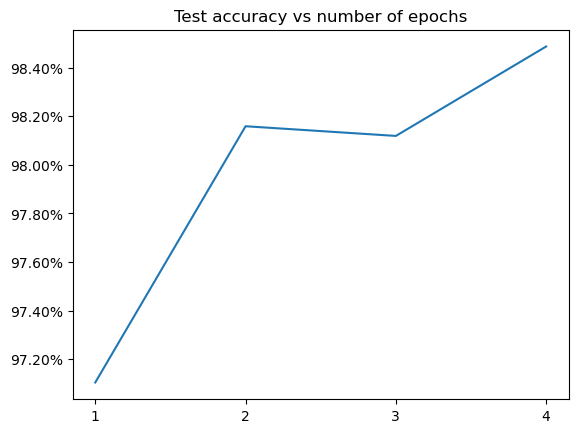

In [9]:
# Test accuracy vs number of epochs
plt.subplot(1, 1, 1)
plt.subplots_adjust(hspace = 0.5)
plt.plot(np.asarray(test_accuracy)*100)
plt.xticks(np.arange(len(test_accuracy)), np.arange(1, len(test_accuracy)+1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Test accuracy vs number of epochs')
plt.savefig("A2_Q2a")

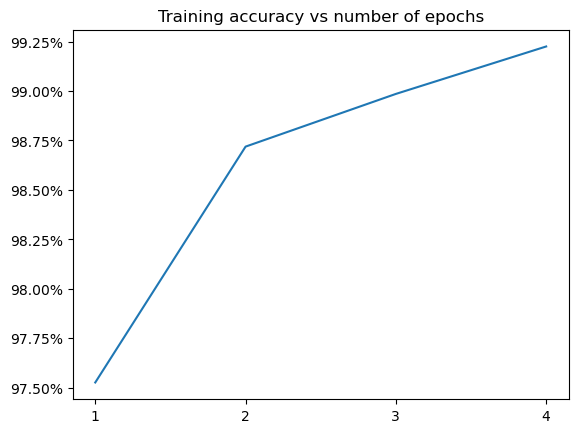

In [10]:
# Training accuracy vs number of epochs
plt.subplot(1, 1, 1)   
plt.plot(np.asarray(train_accuracy)*100)
plt.xticks(np.arange(len(train_accuracy)), np.arange(1, len(train_accuracy)+1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Training accuracy vs number of epochs')
plt.savefig("A2_Q2b")

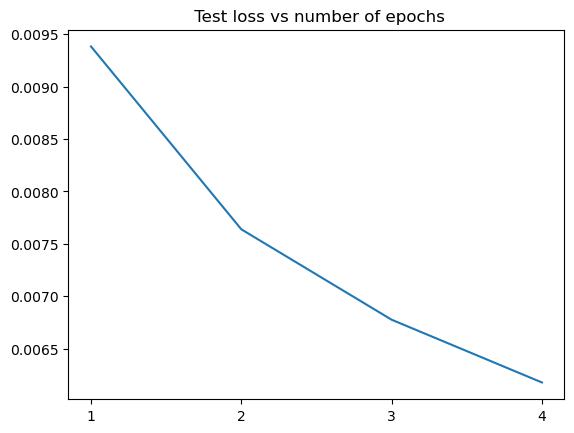

In [11]:
# Test loss vs number of epochs
plt.subplot(1, 1, 1)
plt.subplots_adjust(hspace = 0.5)
plt.plot(test_loss)
plt.xticks(np.arange(len(test_loss)), np.arange(1, len(test_loss)+1))
plt.title(' Test loss vs number of epochs')
plt.savefig("A2_Q2c")

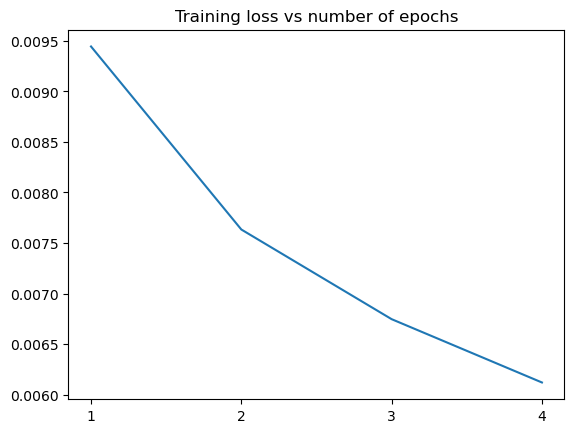

In [12]:
# Training loss vs number of epochs
plt.subplot(1, 1, 1)
plt.plot(train_loss)
plt.xticks(np.arange(len(train_loss)), np.arange(1, len(train_loss)+1))
plt.title('Training loss vs number of epochs')
plt.savefig("A2_Q2d")